In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### a. ELU
*Exercise: Build a DNN with 20 hidden layers of 100 neurons each (that's too many, but it's the point of this exercise). Use He initialization and the ELU activation function.*

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
# use the first 5000 images as validation set
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

170500096/170498071 [==============================] - 1727s 10us/step


In [16]:
X_train.shape, y_train.shape, len(np.unique(y_train))

((45000, 32, 32, 3), (45000, 1), 10)

In [50]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [51]:
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape = X_train.shape[1:]))
for _ in range(20):
    model.add(keras.layers.Dense(units=100, activation='elu', kernel_initializer='he_normal'))
model.add(keras.layers.Dense(10, activation='softmax'))

### b. Explore lr
*Exercise: Using Nadam optimization and early stopping, train the network on the CIFAR10 dataset. You can load it with `keras.datasets.cifar10.load_data()`. The dataset is composed of 60,000 32 × 32–pixel color images (50,000 for training, 10,000 for testing) with 10 classes, so you'll need a softmax output layer with 10 neurons. Remember to search for the right learning rate each time you change the model's architecture or hyperparameters.*

Find a reasonable learning rate

In [41]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = len(X) // batch_size * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [42]:
lr0 = 5e-4
optimizer = keras.optimizers.Nadam(learning_rate=lr0)

model.compile(loss='sparse_categorical_crossentropy',
             optimizer = optimizer,
             metrics = ['accuracy'])

1407/1407 [==============================] - 10s 7ms/step - loss: nan - accuracy: 0.1066


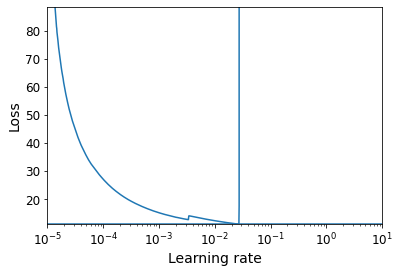

In [43]:
batch_size = 32
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

Around 0.05 (50e-3) train loss shoots up. 10 times smaller than that is 0.005 (5e-3). ---> This lr doesnt work well at all.
Use what the author used instead. How did he find this rate??

In [52]:
optimizer = keras.optimizers.Nadam(learning_rate=5e-5)
model.compile(loss='sparse_categorical_crossentropy',
             optimizer = optimizer,
             metrics = ['accuracy'])

In [56]:
run_index = run_index+1 if run_index else 1
run_logdir = os.path.join(os.curdir, 'my_cifar10_logs', 'run_{:03d}'.format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

earlystop_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
# checkpoint_cb = keras.callbacks.ModelCheckpoint('my_models/cifar10.h5', save_best_only=True)
# callbacks = [checkpoint_cb, earlystop_cb, tensorboard_cb]

In [57]:
n_epochs, batch_size = 100, 32
history = model.fit(X_train, y_train, epochs = n_epochs,
          validation_data=(X_valid, y_valid),
          callbacks = [earlystop_cb, tensorboard_cb])

Epoch 1/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.8177 - accuracy: 0.3405 - val_loss: 1.7975 - val_accuracy: 0.3436
Epoch 2/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.7642 - accuracy: 0.3611 - val_loss: 1.7822 - val_accuracy: 0.3498
Epoch 3/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.7181 - accuracy: 0.3780 - val_loss: 1.7215 - val_accuracy: 0.3824
Epoch 4/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.6795 - accuracy: 0.3921 - val_loss: 1.7674 - val_accuracy: 0.3760
Epoch 5/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.6503 - accuracy: 0.4043 - val_loss: 1.7025 - val_accuracy: 0.3838
Epoch 6/100
1407/1407 [==============================] - 11s 8ms/step - loss: 1.6228 - accuracy: 0.4136 - val_loss: 1.6487 - val_accuracy: 0.4106
Epoch 7/100
1407/1407 [==============================] - 11s 8ms/step - loss: 1.5942 - accuracy: 0.4252 - val_loss: 1.6493 - 

In [59]:
# model = keras.models.load_model("my_models/cifar10.h5")
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 0s 2ms/step - loss: 1.5184 - accuracy: 0.4632


[1.5183756351470947, 0.46320000290870667]

save and load model leads to different results.

In [63]:
keras.models.save_model(model, "my_models/cifar10.h5")
model_loaded = keras.models.load_model("my_models/cifar10.h5")
model_loaded.evaluate(X_valid, y_valid)

157/157 [==============================] - 0s 1ms/step - loss: 1.5184 - accuracy: 0.1104


[1.5183756351470947, 0.1103999987244606]

In [68]:
model_loaded = keras.models.load_model("my_models/cifar10.h5")
model_loaded.load_weights("my_models/cifar10.h5")
model_loaded.evaluate(X_valid, y_valid)

157/157 [==============================] - 0s 1ms/step - loss: 1.5184 - accuracy: 0.1104


[1.5183756351470947, 0.1103999987244606]

In [72]:
loaded_w = model_loaded.get_weights() 
original_w = model.get_weights()
assert len(loaded_w) == len(original_w)
for idx in range(len(original_w)):
    assert np.array_equal(loaded_w[idx], original_w[idx])

No assert errors. But why does the model evaluation return different results?

In [97]:
model.evaluate(X_valid, y_valid)
model_loaded.evaluate(X_valid, y_valid)

157/157 [==============================] - 0s 1ms/step - loss: 1.5184 - accuracy: 0.1104


[1.5183756351470947, 0.1103999987244606]

In [78]:
np.array_equal(model.predict_proba(X_valid), model_loaded.predict_proba(X_valid))

True

In [79]:
from sklearn.metrics import accuracy_score

In [90]:
print('Original Model Validation Accuracy', accuracy_score(y_valid, np.argmax(model.predict_proba(X_valid),axis=1).reshape(-1, 1)))
print('Loaded Model Validation Accuracy', accuracy_score(y_valid, np.argmax(model_loaded.predict_proba(X_valid),axis=1).reshape(-1, 1)))

Original Model Validation Accuracy 0.4632
Loaded Model Validation Accuracy 0.4632


**Reloaded model returns different results/predictions when using loaded_model.evaluate(), even though the weights are correct and the same as the original model. Using model.predict_proba will give the correct evaluation.**

### c. Batch Normalization
*Exercise: Now try adding Batch Normalization and compare the learning curves: Is it converging faster than before? Does it produce a better model? How does it affect training speed?*

Things to try out:
- two BN models: 1. BN after activiation 2. BN before activation
- try out several learning rates, compare their validation loss after 20 epochs & pick the best one
- rename run directories to run_bn_* and the model file name to cifar10_bn_[bf|af]_model.h5

In [119]:
from collections import defaultdict

In [121]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# define BN after activation model
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape = X_train.shape[1:]))
model.add(keras.layers.BatchNormalization())
for _ in range(20):
    model.add(keras.layers.Dense(units=100, activation='elu', kernel_initializer='he_normal'))
    model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(10, activation='softmax'))

# pick a good learning rate with 20 epochs
lr_dict = defaultdict(list)
lr_dict['lr'] = [1e-5, 3e-5, 5e-5, 1e-4, 3e-4, 5e-4, 1e-3, 3e-3, 5e-3]

for lr in lr_dict['lr']:
    optimizer = keras.optimizers.Nadam(learning_rate=lr)
    model.compile(loss='sparse_categorical_crossentropy',
                 optimizer = optimizer,
                 metrics = ['accuracy'])
    model.fit(X_train, y_train, epochs = 20,
                validation_data=(X_valid, y_valid))
    lr_dict['af_val_loss'].append(model.history.history['val_loss'][-1])

Epoch 1/20
1407/1407 [==============================] - 15s 11ms/step - loss: 2.5833 - accuracy: 0.1372 - val_loss: 2.3243 - val_accuracy: 0.1854
Epoch 2/20
1407/1407 [==============================] - 15s 11ms/step - loss: 2.2340 - accuracy: 0.2030 - val_loss: 2.1113 - val_accuracy: 0.2442
Epoch 3/20
1407/1407 [==============================] - 16s 11ms/step - loss: 2.0992 - accuracy: 0.2450 - val_loss: 1.9924 - val_accuracy: 0.2856
Epoch 4/20
1407/1407 [==============================] - 16s 12ms/step - loss: 2.0138 - accuracy: 0.2721 - val_loss: 1.9116 - val_accuracy: 0.3146
Epoch 5/20
1407/1407 [==============================] - 17s 12ms/step - loss: 1.9473 - accuracy: 0.2986 - val_loss: 1.8598 - val_accuracy: 0.3256
Epoch 6/20
1407/1407 [==============================] - 17s 12ms/step - loss: 1.8995 - accuracy: 0.3155 - val_loss: 1.8181 - val_accuracy: 0.3414
Epoch 7/20
1407/1407 [==============================] - 18s 13ms/step - loss: 1.8634 - accuracy: 0.3311 - val_loss: 1.7774 -

The BN before activation model is not run due to long waiting time.

In [122]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# define BN before activation model
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape = X_train.shape[1:]))
model.add(keras.layers.BatchNormalization())
for _ in range(20):
    model.add(keras.layers.Dense(units=100, kernel_initializer='he_normal', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('elu'))
model.add(keras.layers.Dense(10, activation='softmax'))

# pick a good learning rate with 20 epochs
for lr in lr_dict['lr']:
    print('\n\nProcessing learning rate = {}'.format(lr))
    optimizer = keras.optimizers.Nadam(learning_rate=lr)
    model.compile(loss='sparse_categorical_crossentropy',
                 optimizer = optimizer,
                 metrics = ['accuracy'])
    model.fit(X_train, y_train, epochs = 20,
                validation_data=(X_valid, y_valid))
    lr_dict['bf_val_loss'].append(model.history.history['val_loss'][-1])



Processing learning rate = 1e-05
Epoch 1/20


KeyboardInterrupt: 

Text(0.5, 1.0, 'BN after activation')

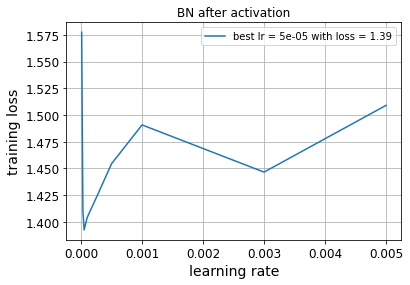

In [137]:
best_lr = lr_dict['lr'][np.argmin(lr_dict['af_val_loss'])]
lowest_loss = np.min(lr_dict['af_val_loss'])

# pd.DataFrame(lr_dict).set_index('lr').plot()
plt.plot(lr_dict['lr'], lr_dict['af_val_loss'], label=f'best lr = {best_lr:.0e} with loss = {lowest_loss:.2f}')
plt.grid(True)
plt.legend()
plt.xlabel('learning rate')
plt.ylabel('training loss')
plt.title('BN after activation')

Rerun model for 100 epochs with best_lr found.

In [138]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# define BN after activation model
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape = X_train.shape[1:]))
model.add(keras.layers.BatchNormalization())
for _ in range(20):
    model.add(keras.layers.Dense(units=100, activation='elu', kernel_initializer='he_normal'))
    model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(10, activation='softmax'))

# let optimizer use best lr found
best_lr = lr_dict['lr'][np.argmin(lr_dict['af_val_loss'])]
optimizer = keras.optimizers.Nadam(learning_rate=best_lr)

# define callbacks
run_index = 3
run_logdir = os.path.join(os.curdir, 'my_cifar10_logs', 'run_{:03d}'.format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
earlystop_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
# checkpoint_cb = keras.callbacks.ModelCheckpoint('my_models/cifar10.h5', save_best_only=True)

model.compile(loss='sparse_categorical_crossentropy',
             optimizer = optimizer,
             metrics = ['accuracy'])
model.fit(X_train, y_train, epochs = 100,
         validation_data=(X_valid, y_valid), 
         callbacks=[earlystop_cb, tensorboard_cb])

Epoch 1/100
1407/1407 [==============================] - 20s 14ms/step - loss: 2.2277 - accuracy: 0.2154 - val_loss: 1.8954 - val_accuracy: 0.3078
Epoch 2/100
1407/1407 [==============================] - 15s 11ms/step - loss: 1.9041 - accuracy: 0.3150 - val_loss: 1.7629 - val_accuracy: 0.3598
Epoch 3/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.8093 - accuracy: 0.3517 - val_loss: 1.6824 - val_accuracy: 0.3976
Epoch 4/100
1407/1407 [==============================] - 16s 12ms/step - loss: 1.7389 - accuracy: 0.3776 - val_loss: 1.6357 - val_accuracy: 0.4178
Epoch 5/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.6905 - accuracy: 0.3956 - val_loss: 1.5892 - val_accuracy: 0.4344
Epoch 6/100
1407/1407 [==============================] - 16s 12ms/step - loss: 1.6502 - accuracy: 0.4112 - val_loss: 1.5540 - val_accuracy: 0.4428
Epoch 7/100
1407/1407 [==============================] - 18s 13ms/step - loss: 1.6127 - accuracy: 0.4261 - val_loss: 1

[1.3592209815979004, 0.521399974822998]

In [139]:
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 0s 2ms/step - loss: 1.3592 - accuracy: 0.5214


[1.3592209815979004, 0.521399974822998]

### d. SELU
*Exercise: Try replacing Batch Normalization with SELU, and make the necessary adjustements to ensure the network self-normalizes (i.e., standardize the input features, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers, etc.).*

In [143]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# standardize the input
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)
X_train_scaled = (X_train - X_mean) / X_std
X_valid_scaled = (X_valid - X_mean) / X_std
X_test_scaled = (X_test - X_mean) / X_std

# define dense model with selu as activation
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape = X_train_scaled.shape[1:]))
for _ in range(20):
    model.add(keras.layers.Dense(units=100, activation='selu', kernel_initializer='lecun_normal'))
model.add(keras.layers.Dense(10, activation='softmax'))

# model has been changed, so the previous best lr may not be applicable here any more.
optimizer = keras.optimizers.Nadam(learning_rate=5e-4)

# define callbacks
run_index = 4
run_logdir = os.path.join(os.curdir, 'my_cifar10_logs', 'run_{:03d}'.format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
earlystop_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
# checkpoint_cb = keras.callbacks.ModelCheckpoint('my_models/cifar10.h5', save_best_only=True)

model.compile(loss='sparse_categorical_crossentropy',
             optimizer = optimizer,
             metrics = ['accuracy'])
model.fit(X_train_scaled, y_train, epochs = 100,
         validation_data=(X_valid_scaled, y_valid), 
         callbacks=[earlystop_cb, tensorboard_cb])

Epoch 1/100
1407/1407 [==============================] - 9s 7ms/step - loss: 1.9002 - accuracy: 0.3223 - val_loss: 1.8407 - val_accuracy: 0.3538
Epoch 2/100
1407/1407 [==============================] - 9s 7ms/step - loss: 1.6886 - accuracy: 0.4015 - val_loss: 1.7004 - val_accuracy: 0.3894
Epoch 3/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.5869 - accuracy: 0.4402 - val_loss: 1.6567 - val_accuracy: 0.4100
Epoch 4/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.5144 - accuracy: 0.4642 - val_loss: 1.6198 - val_accuracy: 0.4412
Epoch 5/100
1407/1407 [==============================] - 11s 8ms/step - loss: 1.4567 - accuracy: 0.4884 - val_loss: 1.5307 - val_accuracy: 0.4576
Epoch 6/100
1407/1407 [==============================] - 11s 8ms/step - loss: 1.4099 - accuracy: 0.5030 - val_loss: 1.5200 - val_accuracy: 0.4714
Epoch 7/100
1407/1407 [==============================] - 11s 8ms/step - loss: 1.3615 - accuracy: 0.5257 - val_loss: 1.5628 - v

In [144]:
model.evaluate(X_valid_scaled, y_valid)

157/157 [==============================] - 0s 2ms/step - loss: 1.4597 - accuracy: 0.5042


[1.4596701860427856, 0.5041999816894531]

### e. SELU with MC alpha dropout
*Exercise: Try regularizing the model with alpha dropout. Then, without retraining your model, see if you can achieve better accuracy using MC Dropout.*

In [147]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# standardize the input
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)
X_train_scaled = (X_train - X_mean) / X_std
X_valid_scaled = (X_valid - X_mean) / X_std
X_test_scaled = (X_test - X_mean) / X_std

# define dense model with selu as activation
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape = X_train_scaled.shape[1:]))
for _ in range(20):
    model.add(keras.layers.Dense(units=100, activation='selu', kernel_initializer='lecun_normal'))
model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation='softmax'))

# model has been changed, so the previous best lr may not be applicable here any more.
optimizer = keras.optimizers.Nadam(learning_rate=5e-4)

# define callbacks
run_index = 5
run_logdir = os.path.join(os.curdir, 'my_cifar10_logs', 'run_{:03d}'.format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
earlystop_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
# checkpoint_cb = keras.callbacks.ModelCheckpoint('my_models/cifar10.h5', save_best_only=True)

model.compile(loss='sparse_categorical_crossentropy',
             optimizer = optimizer,
             metrics = ['accuracy'])
model.fit(X_train_scaled, y_train, epochs = 100,
         validation_data=(X_valid_scaled, y_valid), 
         callbacks=[earlystop_cb, tensorboard_cb])

Epoch 1/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.8973 - accuracy: 0.3245 - val_loss: 1.7629 - val_accuracy: 0.3738
Epoch 2/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.6699 - accuracy: 0.4083 - val_loss: 1.6686 - val_accuracy: 0.4106
Epoch 3/100
1407/1407 [==============================] - 9s 7ms/step - loss: 1.5760 - accuracy: 0.4470 - val_loss: 1.6626 - val_accuracy: 0.4274
Epoch 4/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.5062 - accuracy: 0.4709 - val_loss: 1.5549 - val_accuracy: 0.4532
Epoch 5/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.4490 - accuracy: 0.4949 - val_loss: 1.7011 - val_accuracy: 0.4476
Epoch 6/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.4065 - accuracy: 0.5115 - val_loss: 1.5401 - val_accuracy: 0.4778
Epoch 7/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.3609 - accuracy: 0.5255 - val_loss: 1.6347 - va

In [148]:
model.evaluate(X_valid_scaled, y_valid)

157/157 [==============================] - 0s 2ms/step - loss: 1.5054 - accuracy: 0.4968


[1.505418062210083, 0.4968000054359436]

#### Implement MCDropout

In [160]:
# subclass alphadropout
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

# create a new model replacing alphadropout with MCalphadropout
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [161]:
# create some utils functions
def predict_mc_probas(mc_model, inputs, runs=10):
    probas = [mc_model.predict(inputs) for _ in range(runs)]
    mean_probas = np.mean(probas, axis=0)
    return mean_probas

def predict_mc_class(mc_model, inputs, runs=10):
    mean_probas = predict_mc_probas(mc_model, inputs, runs)
    return np.argmax(mean_probas, axis=1)

In [168]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

y_valid_pred = predict_mc_class(mc_model, X_valid_scaled)
accuracy = np.mean(y_valid.ravel() == y_valid_pred)
accuracy

0.4966

### f. 1cycle
*Exercise: Retrain your model using 1cycle scheduling and see if it improves training speed and model accuracy.*

In [169]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [189]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# define dense model with selu as activation
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape = X_train_scaled.shape[1:]))
for _ in range(20):
    model.add(keras.layers.Dense(units=100, activation='selu', kernel_initializer='lecun_normal'))
model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation='softmax'))

optimizer = keras.optimizers.SGD(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

1407/1407 [==============================] - 4s 3ms/step - loss: nan - accuracy: 0.1542


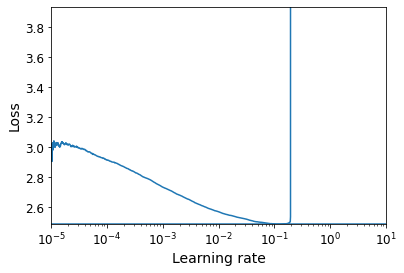

In [190]:
batch_size = 32
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)
plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 1.4])
pass

In [191]:
rates[np.argmin(losses)]

0.19829562

In [193]:
lr0 = 0.015
max_lr = 0.15

In [194]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# define dense model with selu as activation
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape = X_train_scaled.shape[1:]))
for _ in range(20):
    model.add(keras.layers.Dense(units=100, activation='selu', kernel_initializer='lecun_normal'))
model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation='softmax'))

optimizer = keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [195]:
n_epochs = 25
onecycle = OneCycleScheduler(len(X_train_scaled) // batch_size * n_epochs, max_rate=max_lr)

model.fit(X_train_scaled, y_train, epochs = n_epochs, batch_size=batch_size,
         validation_data=(X_valid_scaled, y_valid), 
         callbacks=[onecycle])

Epoch 1/25
1407/1407 [==============================] - 4s 3ms/step - loss: 1.9011 - accuracy: 0.3226 - val_loss: 1.8523 - val_accuracy: 0.3310
Epoch 2/25
1407/1407 [==============================] - 4s 3ms/step - loss: 1.6931 - accuracy: 0.3969 - val_loss: 2.1477 - val_accuracy: 0.3182
Epoch 3/25
1407/1407 [==============================] - 4s 3ms/step - loss: 1.6369 - accuracy: 0.4211 - val_loss: 2.0074 - val_accuracy: 0.3690
Epoch 4/25
1407/1407 [==============================] - 4s 3ms/step - loss: 1.6001 - accuracy: 0.4354 - val_loss: 2.0351 - val_accuracy: 0.3612
Epoch 5/25
1407/1407 [==============================] - 4s 3ms/step - loss: 1.5805 - accuracy: 0.4489 - val_loss: 1.9343 - val_accuracy: 0.3644
Epoch 6/25
1407/1407 [==============================] - 4s 3ms/step - loss: 1.5753 - accuracy: 0.4547 - val_loss: 1.6658 - val_accuracy: 0.4134
Epoch 7/25
1407/1407 [==============================] - 4s 3ms/step - loss: 1.5672 - accuracy: 0.4552 - val_loss: 1.8454 - val_accuracy: